In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from scipy.optimize import fmin_slsqp
import numpy as np
import matplotlib.pyplot as plt
from time import time
import os
import sys
from pathlib import Path
ROOT_PATH = Path().absolute().parent
if str(ROOT_PATH) not in sys.path:
    sys.path.insert(1, str(ROOT_PATH))
from frequency_response import FrequencyResponse
from biquad import peaking, digital_coeffs

In [3]:
fr = FrequencyResponse.read_from_csv(ROOT_PATH.joinpath('results', 'oratory1990', 'harman_over-ear_2018', 'Audeze LCD-4', 'Audeze LCD-4.csv'))

In [40]:
def print_filters(filters):
    print(', '.join([f'{fc:.0f} Hz' for fc in filters[:, 0]]))
    print(', '.join([f'{q:.2f} Q' for q in filters[:, 1]]))
    print(', '.join([f'{gain:.1f} dB' for gain in filters[:, 2]]))
    #for fc, q, gain in filters:
    #    print(f'{fc:.0f} Hz, {q:.3f} Q, {gain:.1f} dB')

In [90]:
def compare(fp, n):
    fr = FrequencyResponse.read_from_csv(fp)
    t = time()
    old_peq = fr.parametric_eq.copy()
    filters, _ = fr.optimize_peq(n, 48000)
    fr.fixed_band_eq = fr.parametric_eq.copy()
    fr.parametric_eq = old_peq
    t = time() - t
    #fr.optimize_parametric_eq(max_filters=n)
    ix = np.sum(fr.frequency < 10e3)
    new_rmse = np.sqrt(np.mean(np.square(fr.equalization[:ix] - fr.fixed_band_eq[:ix])))
    old_rmse = np.sqrt(np.mean(np.square(fr.equalization[:ix] - fr.parametric_eq[:ix])))
    print(f'{fr.name}: RMSE {old_rmse:.2f} -> {new_rmse:.2f}  = {"+" if new_rmse > old_rmse else ""}{new_rmse - old_rmse:.2f} dB ({(new_rmse - old_rmse) / old_rmse * 100:.1f} %) @ {t*1000:.0f} ms')
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(26, 8)
    FrequencyResponse.init_plot(fig=fig, ax=axs[1])
    fr.plot_graph(fig=fig, ax=axs[0], fixed_band_eq_plot_kwargs={'label': 'New optimizer'}, show=False)
    for fc, q, gain in filters:
        axs[1].plot(fr.frequency, digital_coeffs(fr.frequency, 48e3, *peaking(fc, q, gain, fs=48e3), reduce=True), label=f'{fc:.0f} Hz, {q:.3f} Q, {gain:.1f} dB')
    axs[1].legend()
    axs[1].set_title('Parametric Filters')
    plt.show()

C:\Users\jaakko\code\AutoEq\venv\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


1MORE Quad Driver: RMSE 0.42 -> 0.26  = -0.16 dB (-38.9 %) @ 589 ms


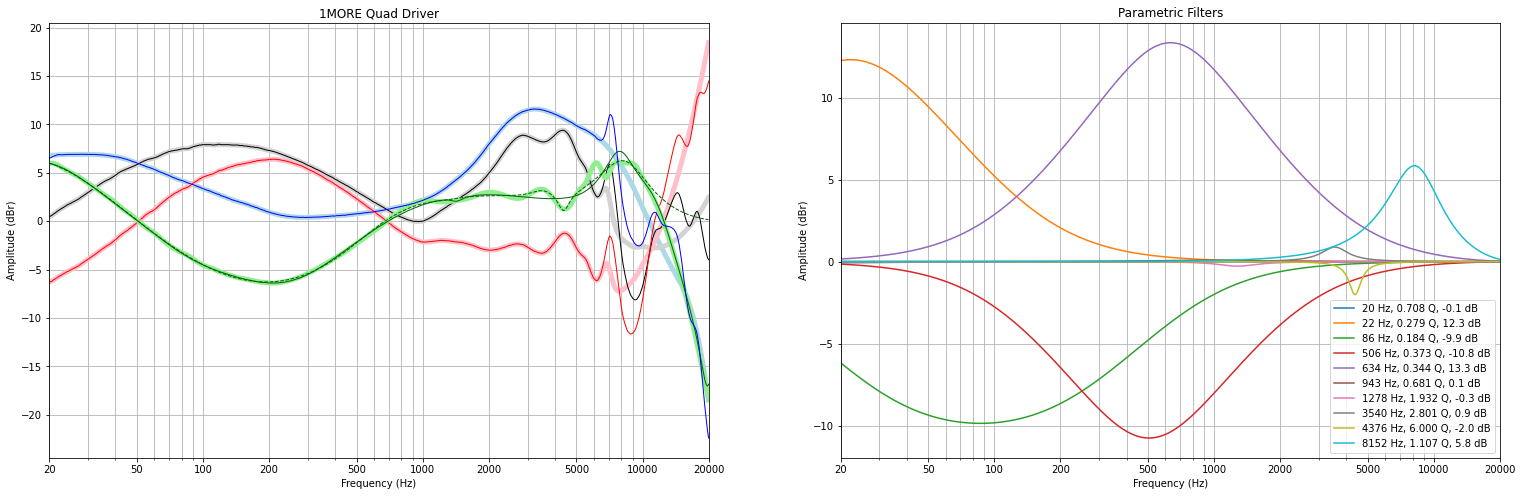

In [92]:
n = [5, 5]
for fp in ROOT_PATH.joinpath('results', 'oratory1990').glob('*/*/*.csv'):
    compare(fp, n)
    break